# Template Molecule-based Temperature Map
## December 6, 2021

Should comment this extesively.

## Index 

 * [Step 1: Retrieve data on lines](##Step-1:-Retrieve-data-on-lines)
 * [Step 2: Generate noise map](##Step-2:-Generate-noise-map)
 * [Step 3: Generate N_upper from mom0, propagate errors](##Step-3:-Generate-N_upper-from-mom0,-propagate-errors)
 * [Step 4: Prepare for fitting temperature and N_tot, filtration step](##Step-4:-Prepare-for-fitting-temperature-and-N_tot,-filtration-step)
 * [Step 5: Fit temperature and N_tot](##Step-5:-Fit-temperature-and-N_tot)
 * [Step 6: Loop over each pixel to make maps](##Step-6:-Loop-over-each-pixel-to-make-maps)
 * [Step 7: Check rotational diagrams for individual pixels](##Step-7:-Check-rotational-diagrams-for-individual-pixels)


In [1]:
%matplotlib inline

import pylab as pl
# pl.style.use('dark_background')
# pl.rcParams['figure.facecolor'] = 'w'

# plt.rc('text', usetex = True) # Use LaTeX font in plots
# plt.rc('font', family = 'serif')
# plt.rcParams['text.latex.preamble'] = r'\usepackage{gensymb}'
# pl.rcParams.update({'font.size': 12})
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

## Step 1: Retrieve data on lines

First, we'll retrieve some values we need for each rung from the methyl cyanide cube table.

In [2]:
from spectral_cube import SpectralCube
from astropy import units as u
from lte_modeling_tools import get_molecular_parameters
from astropy import constants

# User inputs
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '146_spw51'
fmin = 147.035*u.GHz # ch3cncube.spectral_axis.min() # I should not have to hard-code these...
fmax = 147.175*u.GHz # ch3cncube.spectral_axis.max()

In [3]:
def retrieve_cube(results, freq_spw):
    '''Get methyl cyanide (target molecule) cube'''
    fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
    ch3cncube = SpectralCube.read(fn, format='casa_image')
    ch3cn_freqs, ch3cn_A, ch3cn_g, ch3cn_E_U, ch3cn_partfunc = get_molecular_parameters('CH3CN',
                                                                                        fmin=fmin, 
                                                                                        fmax=fmax, 
                                                                                        catalog='JPL')
    # We're readying the partition function for use with temperature map later!
    ch3cn_A = 10**ch3cn_A*u.s**-1 # Original is log_10(A_ij)
    # DO NOT RUN THE FOLLOWING LINE, WHATEVER YOU DO
    #ch3cn_E_U = ch3cn_E_U/constants.k_B # Original is in erg
    return ch3cncube, ch3cn_freqs, ch3cn_A, ch3cn_g, ch3cn_E_U, ch3cn_partfunc

In [4]:
ch3cncube, ch3cn_freqs, ch3cn_A, ch3cn_g, ch3cn_E_U, ch3cn_partfunc = retrieve_cube(results, freq_spw)

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [64]:
ch3cn_freqs

<Quantity [147035.8351, 147072.6021, 147103.738 , 147129.2302, 147149.0683,
           147163.2441, 147171.7519, 147174.5883] MHz>

## Step 2: Generate noise map

Now, we'll import the noise map, from which we'll begin error propagation.

In [5]:
from pylab import imshow
from astropy.io import fits

In [6]:
def generate_noise_map():
    '''Generate noise map from filename (hard-coded)'''
    hdu = fits.open('methyl_cyanide/template_noise.fits')
    noise_map = hdu[0].data*u.K # Generally, should NOT enforce units like this, but smarter solution
                                # is not implemented yet
    imshow(noise_map.value, origin='lower')
    return noise_map

In [7]:
from astropy.visualization import quantity_support

In [8]:
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b3d02fa9310>

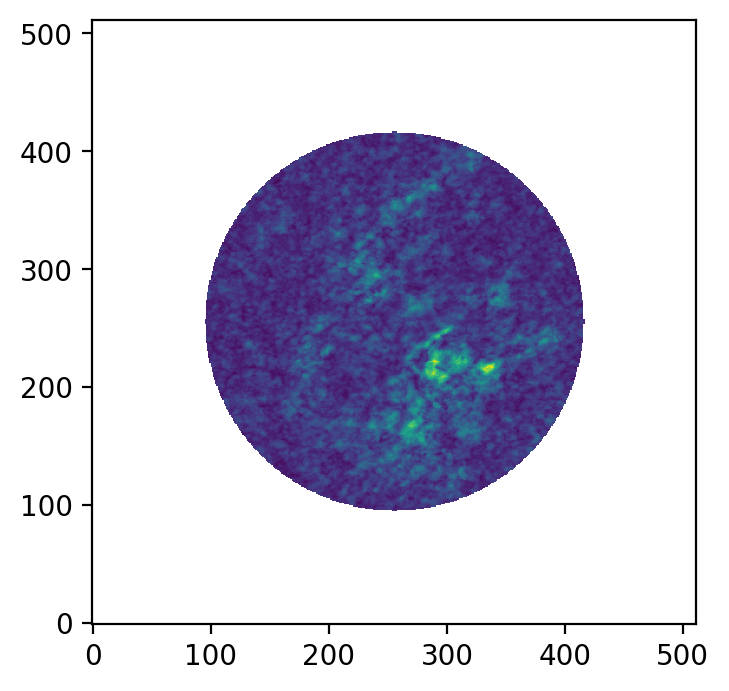

In [9]:
noise_map = generate_noise_map()

In [10]:
# ch3cncube.mad_std(axis = 0)

## Step 3: Generate N_upper from mom0, propagate errors

Should rework this so it doesn't use indices. I did this in the "synthetic spectrum" part of the code in new_temperature_map_messed_up_by_adam or something like that.

Now, we'll go through each rung of the ladder and get the upper state column density from the moment 0 map for each rung. We'll store those upper state column density maps for fitting in the next step, and we'll plot the moment 0 maps next to the upper state column density maps for each *k*-component.

We will also propagate errors on the noise map for each of the *k*-components.

In [11]:
import numpy as np
from lte_modeling_tools import nupper_of_kkms
from astropy import constants

In [12]:
# masked_cube = SpectralCube.read(f'methyl_cyanide/ch3cn_3_masked.fits', format='fits')
# plt.imshow(masked_cube[0])

In [13]:
def generate_N_upper(ch3cn_freqs, ch3cn_A, ch3cn_g):
    '''Get upper state column density maps from filenames (hard-coded)'''
    log_N_upper_gs = []
    log_N_upper_g_errs = []

    i = 0
    for i in range(0, 8):

        # Import masked cube and get channel width
        masked_cube = SpectralCube.read(f'methyl_cyanide/ch3cn_{i}_masked.fits', format='fits')
#         primary_beam = SpectralCube.read(results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.pb', format='casa_image')
#         masked_cube = masked_cube/primary_beam # Correct for effect of primary beam
        channel_width = np.diff(masked_cube.spectral_axis)[0]

        # Calculate moment 0 and moment 1 maps of cube
        mom0 = masked_cube.moment0()
        mom1 = masked_cube.moment1()
        # Propagate error on integrated intensity
        number_of_pixels = masked_cube.mask.include().sum(axis=0)
        noise_map_int = noise_map*channel_width*np.sqrt(number_of_pixels) # Noise map WAS in Jy/beam... now K
            # Why were we not multiplying by the channel width???

        # Calculate what the shifted line frequency for the rung should be (per pixel) with mom1
        #shifted_line_freqs = (ch3cn_freqs[i]-((mom1/(constants.c.to(u.km/u.s)))*ch3cn_freqs[i])).to(u.GHz) # Maybe okay?

        # Calculate upper state column density from integrated line intensity (moment 0 map)
        N_upper = nupper_of_kkms(mom0, ch3cn_freqs[i], ch3cn_A[i])
        log_N_upper_g = np.log10(N_upper.value/ch3cn_g[i]) # Shouldn't have to do .value?
        # Propagate error on upper state column density
        N_upper_err = nupper_of_kkms(noise_map_int, ch3cn_freqs[i], ch3cn_A[i])
        log_N_upper_g_err = N_upper_err/(N_upper*np.log(10.)) # There's no g here b/c it's a constant (divides out)

        # Append upper state column density maps and error maps into lists
        log_N_upper_gs.append(log_N_upper_g)
        log_N_upper_g_errs.append(log_N_upper_g_err)

        # Plot moment 0 and upper state column density maps for each rung next to each other
    #     fig = plt.figure(figsize = (20, 10))
    #     im = plt.subplot(1,2,1).imshow(mom0.value, origin='lower', cmap='magma')
    # #     plt.colorbar(mappable = im)
    #     plt.title(f"Methyl Cyanide $j = 8$, $k = {i}$ Moment 0 Map")
    #     im = plt.subplot(1,2,2).imshow(log_N_upper_g, origin='lower', cmap='magma')
    # #     plt.colorbar(mappable = im)
    #     plt.title(f"Methyl Cyanide $j = 8$, $k = {i}$ Upper State Column Density Map")
    #     plt.show()

        print(np.nanmin(log_N_upper_g))
        print(np.nanmax(log_N_upper_g))

        i += 1

    log_N_upper_gs = np.array(log_N_upper_gs)
    log_N_upper_g_errs = np.array(log_N_upper_g_errs)
    return log_N_upper_gs, log_N_upper_g_errs

In [14]:
log_N_upper_gs, log_N_upper_g_errs = generate_N_upper(ch3cn_freqs, ch3cn_A, ch3cn_g)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


9.7714576246754
11.198147709117977


/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


9.199203619901434
10.542039150376215


/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


9.35634734588619
10.304866086579658


/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


9.26602726436066
10.351424870738446


/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


8.905848522013532
9.731664303494217


/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


9.169104332093799
9.721949869971944


/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


9.147812797389559
9.73792596142655
9.140865600497031
9.640838329331064


/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


## Step 4: Prepare for fitting temperature and N_tot, filtration step

Should clean this up.

In [15]:
# Convert to natural log for fitting
ln_N_upper_gs = np.log(10**(log_N_upper_gs))
ln_N_upper_g_errs = np.log(10**(log_N_upper_g_errs))

# Replace all NaNs with 0s
ln_N_upper_gs = np.nan_to_num(ln_N_upper_gs)
# Set the errors for NaN values to be huge so these are ignored in the fit
ln_N_upper_g_errs = np.nan_to_num(ln_N_upper_g_errs, nan=1e10)

In [16]:
# Sum along k-component axis of NaN/non-NaN mask (which has True for "value," False for NaN)
# /where/ (not "if," as that invokes for loops) sum less than 3, make all values NaN (or 0)
ln_N_upper_gs.shape # (8, 512, 512)
ln_N_upper_gs_mask = ln_N_upper_gs != 0
# ln_N_upper_gs[ln_N_upper_gs_mask] # This does not have the shape I want, it's /just/ the valid values
ln_N_upper_gs_mask_sum = ln_N_upper_gs_mask.sum(axis=0)
ln_N_upper_gs_mask_sum_rep = np.repeat(ln_N_upper_gs_mask_sum[np.newaxis, :, :], 8, axis=0)

ln_N_upper_gs_test = ln_N_upper_gs.copy() # probably don't need to duplicate this?
ln_N_upper_gs_test[ln_N_upper_gs_mask_sum_rep <= 3] = 0 # use boolean mask to apply to upper state col densities

ln_N_upper_gs[ln_N_upper_gs_mask_sum_rep <= 3] = 0 # now officially applying to data! *****
ln_N_upper_g_errs[ln_N_upper_gs_mask_sum_rep <= 3] = 1e10 # errors big = try to ignore these

## Step 5: Fit temperature and N_tot

Let's fit a pixel!

In [17]:
# Don't fit missing data (SHOULD INCORP UPPER LIMITS)
pix_x, pix_y = 319, 220
col_density_NaN_mask = np.isfinite(ln_N_upper_gs[:,pix_y,pix_x]) # ignores NaNs
col_density_zero_mask = ln_N_upper_gs[:,pix_y,pix_x] != 0
fit_energies = (ch3cn_E_U[::-1])[col_density_zero_mask]
fit_col_densities = ln_N_upper_gs[:,pix_y,pix_x][col_density_zero_mask]
fit_col_densities_errs = ln_N_upper_g_errs[:,pix_y,pix_x][col_density_zero_mask]

print(fit_energies)
print(fit_col_densities)
print(fit_col_densities_errs)

[4.38845933e-15 5.37496915e-15 8.33429995e-15 1.32657764e-14
 2.01682662e-14]
[25.16228921 23.95476051 23.03970172 23.34898607 20.96905621]
[0.10781236 0.09657508 0.34619639 0.20639896 0.97305027]


In [18]:
# do the simple linear fit
from scipy.optimize import curve_fit

def linear(x, m, b):
    return m*x + b

# CONVERT TO K FROM ERGS TO DO THE FIT BC ERGS HAD SMALL NUMBERS
fit_energies_converted = (fit_energies*u.erg/constants.k_B).decompose()

# guess = np.array([1e-15, 100])
# Fit without errorbars:
popt, pcov = curve_fit(linear, fit_energies_converted, fit_col_densities) #,  guess
print(popt)
slope, intercept = popt[0], popt[1]

[-0.0298401  25.52248074]


In [19]:
# Fit with errorbars: 
popt, pcov = curve_fit(linear, fit_energies_converted, fit_col_densities, 
                       sigma = fit_col_densities_errs) #,  guess
print(popt)
slope, intercept = popt[0], popt[1]

[-0.02609301 25.43697938]


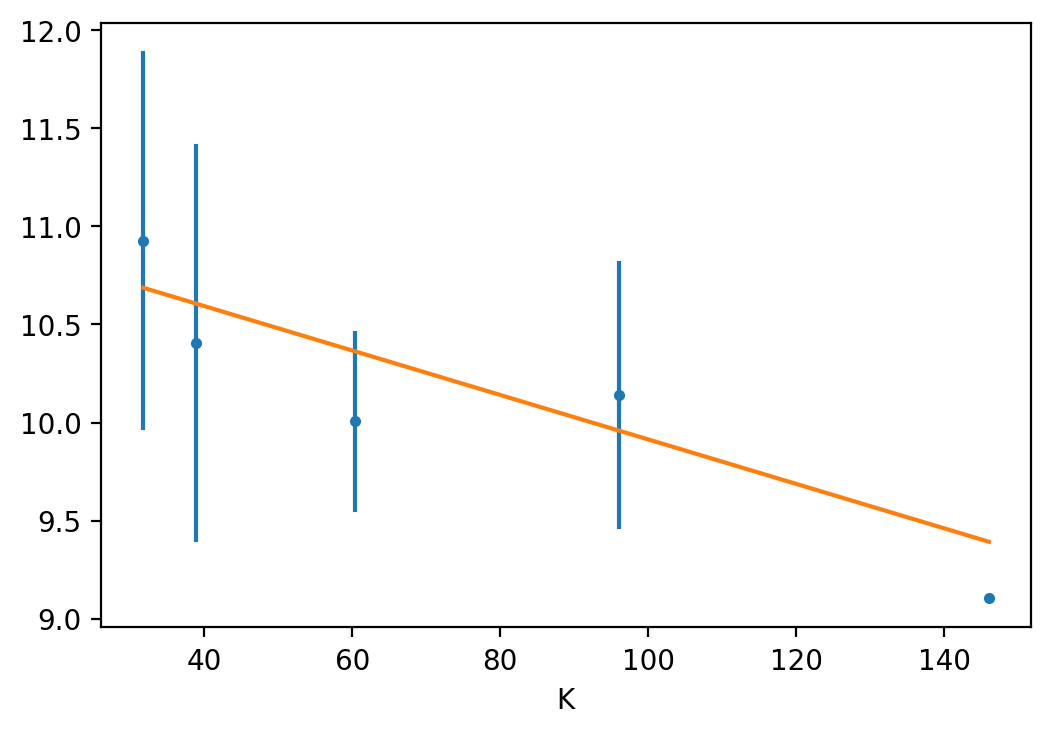

In [20]:
# x_axis = (fit_energies*u.erg/constants.k_B).decompose() # NOW X AXIS IS IN KELVIN
fig = plt.figure(dpi = 200) # I shouldn't have to do this every time
plt.errorbar(fit_energies_converted, np.log10(np.exp(fit_col_densities)),
             yerr = np.log10(fit_col_densities_errs), fmt = '.') # should these both be log10'ed?
plt.plot(fit_energies_converted, np.log10(np.exp(slope*fit_energies_converted.value+intercept)))
plt.show()

In [21]:
# fit_energies_converted[3]
# fit_col_densities[3]

We are making important edits that have implications for other code here:

In [22]:
# channel_width

In [23]:
masked_cube = SpectralCube.read(f'methyl_cyanide/ch3cn_3_masked.fits', format='fits')
channel_width = np.diff(masked_cube.spectral_axis)[0]

print("Noise map:",noise_map[pix_y,pix_x])

number_of_pixels = masked_cube.mask.include().sum(axis=0)[pix_y,pix_x]

noise_map_int = noise_map[pix_y,pix_x]*channel_width*np.sqrt(number_of_pixels)
print("Noise map integrated:",noise_map_int)

mom0 = masked_cube.moment0()
print("mom0 value at pixel:",mom0[pix_y,pix_x])

N_upper = nupper_of_kkms(mom0[pix_y,pix_x], ch3cn_freqs[3], ch3cn_A[3])
print("N_upper:",N_upper)
N_upper_err = nupper_of_kkms(noise_map_int, ch3cn_freqs[3], ch3cn_A[3])
print("Error on N_upper:",N_upper_err)
log_N_upper_g_err = N_upper_err/(N_upper*np.log(10.))
print("Error on log of N_upper:",log_N_upper_g_err)

Noise map: 0.1355228490119575 K
Noise map integrated: 463.6872180631595 K m / s
mom0 value at pixel: 2246.5579139796246 K m / s
N_upper: 469693690067.64606 1 / cm2
Error on N_upper: 96944289365.54091 1 / cm2
Error on log of N_upper: 0.08963792959923064


In [24]:
# # extract the values
# temp = (-1./slope)*u.K # okay, we are assuming that this is the correct interpretation of m vs. b
# # temp = (temp*u.erg/constants.k_B).decompose() # DON'T NEED THIS BC FIT ALREADY DIVIDED BY K_B
# total_col_density = np.log10(np.exp(intercept)*ch3cn_partfunc(temp))

# print(f"Temp: {temp}")
# print(f"log10(Total column density): {total_col_density}")

## Step 6: Loop over each pixel to make maps

Let's now loop this process for each pixel.

In [25]:
from scipy.optimize import curve_fit
import tqdm
print(tqdm.__version__)
from tqdm.notebook import tqdm

4.62.0


In [26]:
def rotational_diagram(pixel_x, pixel_y, plot = False, save = False):
    #  Don't fit missing data (SHOULD INCORP UPPER LIMITS)
    col_density_NaN_mask = np.isfinite(ln_N_upper_gs[:,pixel_y,pixel_x]) # ignores NaNs
    col_density_zero_mask = ln_N_upper_gs[:,pixel_y,pixel_x] != 0
    fit_energies = (ch3cn_E_U[::-1])[col_density_zero_mask]
    fit_col_densities = ln_N_upper_gs[:,pixel_y,pixel_x][col_density_zero_mask]
    fit_col_densities_errs = ln_N_upper_g_errs[:,pixel_y,pixel_x][col_density_zero_mask]
#     print(fit_energies, fit_col_densities)
    
    # do the simple linear fit
    # CONVERT TO K FROM ERGS TO DO THE FIT BC ERGS HAD SMALL NUMBERS
    fit_energies_converted = (fit_energies*u.erg/constants.k_B).decompose()
    # guess = np.array([1e-15, 100])
    popt, pcov = curve_fit(linear, fit_energies_converted, fit_col_densities, sigma = fit_col_densities_errs)
#     print(popt)
    slope, intercept = popt[0], popt[1]
    
    # extract the values
    temp = (-1./slope)*u.K # okay, we are assuming that this is the correct interpretation of m vs. b
    # temp = (temp*u.erg/constants.k_B).decompose() # DON'T NEED THIS BC FIT ALREADY DIVIDED BY K_B
    total_col_density = np.log10(np.exp(intercept)*ch3cn_partfunc(temp))

    if plot == True:
        # x_axis = (fit_energies*u.erg/constants.k_B).decompose() # NOW X AXIS IS IN KELVIN
        plt.errorbar(fit_energies_converted, fit_col_densities, yerr = fit_col_densities_errs, 
                     fmt = 'o', color = 'tab:blue') 
        plt.plot(fit_energies_converted, slope*fit_energies_converted.value+intercept, 
                 label = f"$T$ = {temp:.1f}, $\log_{{10}}(N_{{tot}})$ = {total_col_density:.2f}",
                 color = 'tab:orange') # Why were we exp'ing the y axis???
    #     plt.yscale('log')
        plt.title(f"Rotational diagram for ({pixel_x}, {pixel_y})")
        plt.xlabel(f"Upper state energy [??? K but how get units?]")
        plt.ylabel(f"Column density [??? cm^{-2} but how get units?]")
        plt.legend()
        if save == True:
            plt.savefig("../figures/rot_diagram.pdf", dpi = 200, facecolor='w', edgecolor='w', bbox_inches='tight')
        plt.show()

        # print extracted values
        print(f"Temp: {temp:.5f}")
        print(f"log10(Total column density): {total_col_density:.5f}")

    return temp.value, total_col_density

def linear(x, m, b):
    return m*x + b

In [27]:
energy_K = (ch3cn_E_U[::-1]*u.erg/constants.k_B).decompose()

In [28]:
temp_map = np.zeros(ln_N_upper_gs.shape[1:])
total_col_density_map = np.zeros(ln_N_upper_gs.shape[1:])
for index in tqdm(np.ndindex(ln_N_upper_gs.shape[1:])):
    col_density = ln_N_upper_gs[:,index[0],index[1]]
    col_density_errs = ln_N_upper_g_errs[:,index[0],index[1]]
    # Create column density mask, accounting for NaNs and zeros
    col_density_mask = (col_density != 0) & np.isfinite(col_density)
    if not col_density_mask.sum() > 1: # Are there unmasked values? If no, skip index
        continue
    temp_map[index], total_col_density_map[index] = rotational_diagram(index[1], index[0]) # Should be x, y order for function

0it [00:00, ?it/s]

In [29]:
# # extract the values
# temp_map = (-1./slope_map)*u.K
# # temp = (temp*u.erg/constants.k_B).decompose() # DON'T NEED THIS BC FIT ALREADY DIVIDED BY K_B
# total_col_density_map = np.log10(np.exp(intercept_map)*ch3cn_partfunc(temp_map))

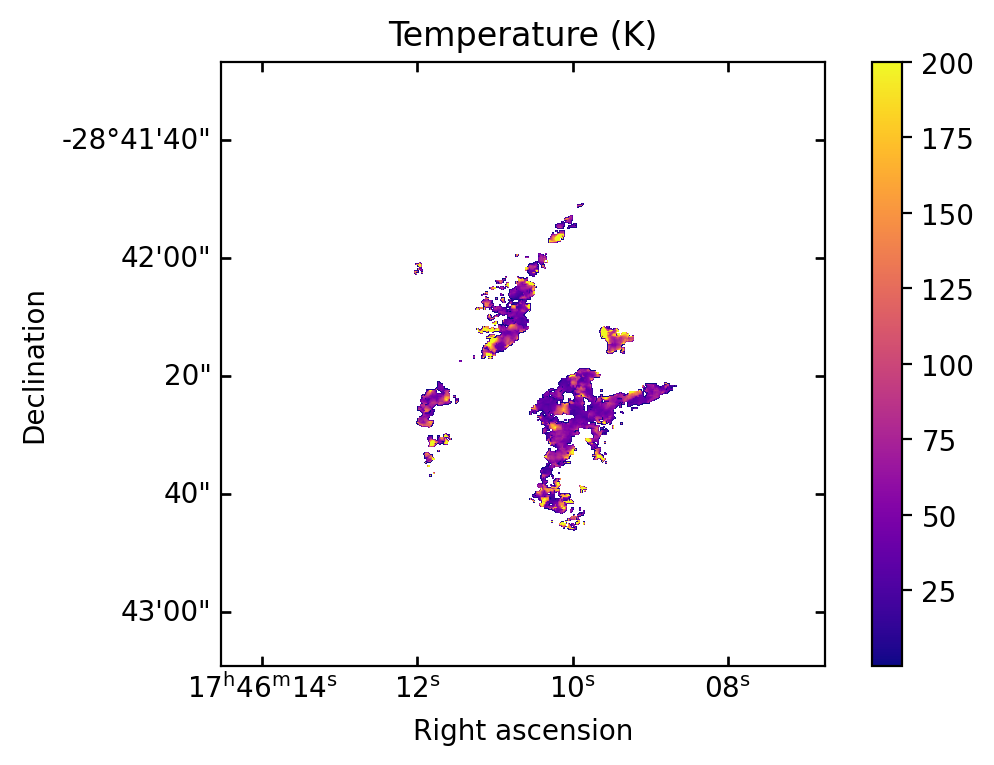

In [30]:
# Set up colormap
# rock = sns.color_palette("rocket", as_cmap=True)
fig = plt.figure(dpi = 200)
cm = pl.matplotlib.cm.plasma.copy()
cm.set_under('w') # Make sure the "zero" color is white

# Get WCS coordinates from an (arbitrary?) masked cube
masked_cube = SpectralCube.read(f'methyl_cyanide/ch3cn_0_masked.fits', format='fits')
mom0 = masked_cube.moment0()

plt.subplot(111,  projection = mom0.wcs)
plt.imshow(temp_map, vmax=200, vmin=0.001, cmap = cm, origin='lower')
plt.tick_params(direction = 'in')
plt.title('Temperature (K)')
plt.xlabel('Right ascension'); plt.ylabel('Declination')
plt.colorbar()
plt.savefig("../figures/temp_map.pdf", dpi = 300, facecolor='w', edgecolor='w', bbox_inches='tight')

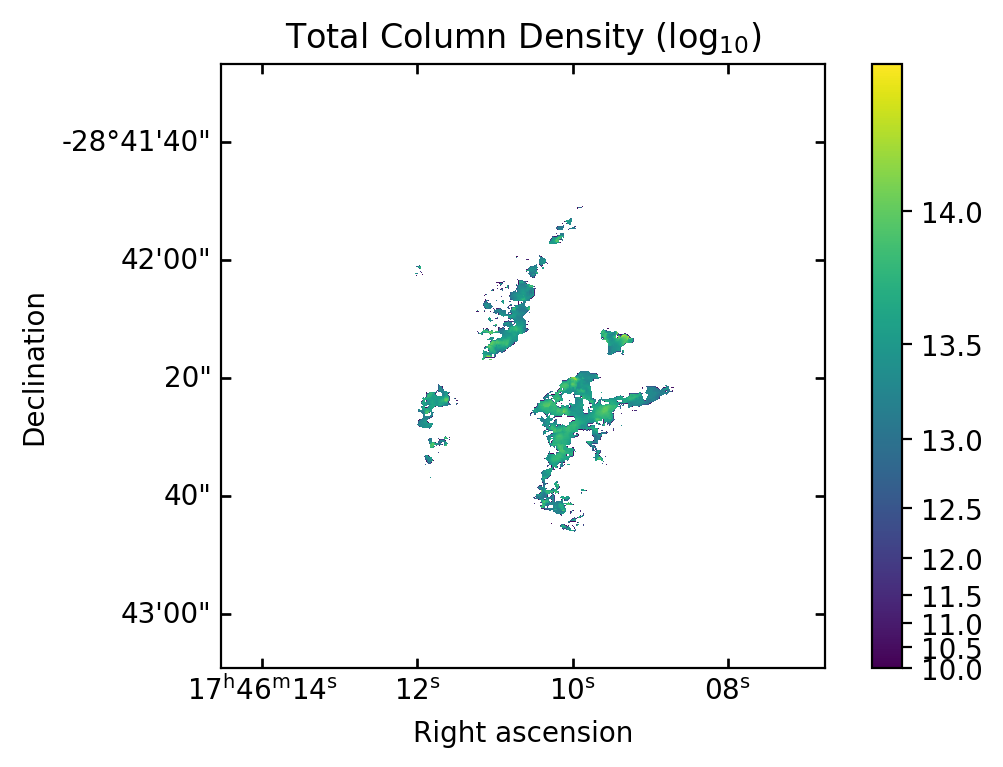

In [31]:
# mako_r = sns.color_palette("mako_r", as_cmap=True)

fig = plt.figure(dpi = 200)

# Set up normalization
from astropy.visualization import imshow_norm, ManualInterval, SqrtStretch, SinhStretch

cm = pl.matplotlib.cm.viridis.copy()
cm.set_under('w') # Make sure the "zero" color is white
# pl.imshow(total_col_density_map, cmap = cm, norm = norm, origin='lower')

plt.subplot(111,  projection = mom0.wcs)
im, norm = imshow_norm(total_col_density_map, origin='lower', cmap = cm, 
                       interval=ManualInterval(vmin = 10, vmax = np.max(total_col_density_map)), 
                       stretch=SinhStretch())
plt.tick_params(direction = 'in')
plt.title('Total Column Density ($\log_{10}$)')
plt.xlabel('Right ascension'); plt.ylabel('Declination')
plt.colorbar(mappable=im)
plt.savefig("../figures/coldens_map.pdf", dpi = 300, facecolor='w', edgecolor='w', bbox_inches='tight')

## Step 7: Check rotational diagrams for individual pixels

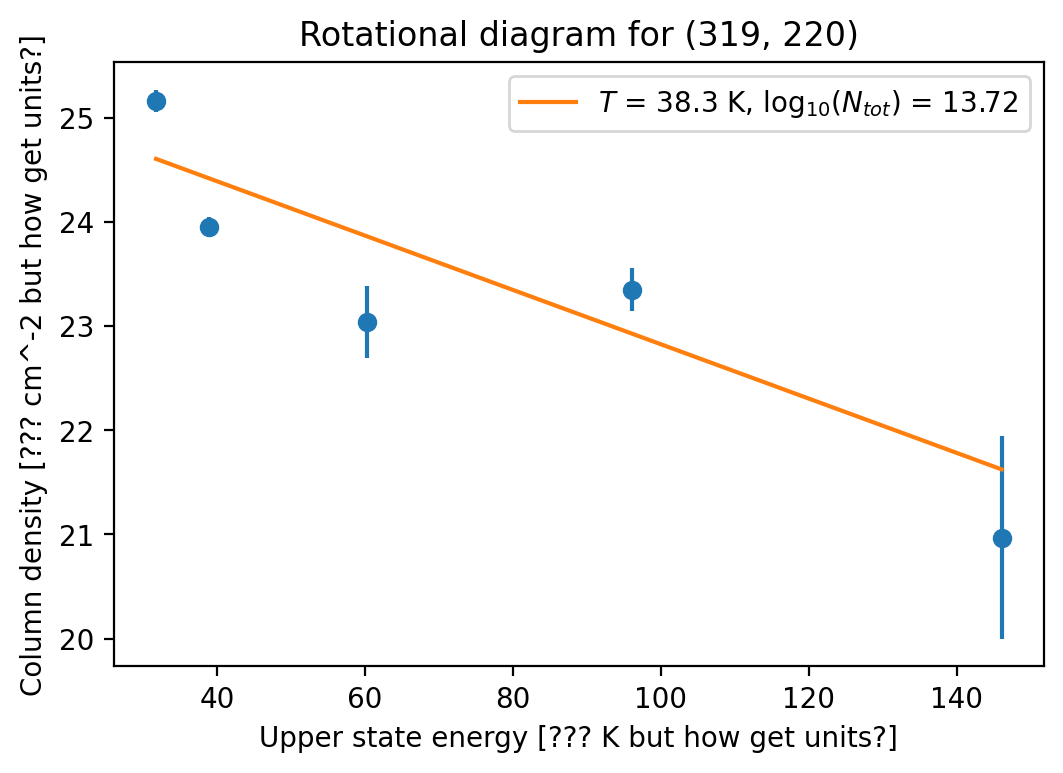

Temp: 38.32444 K
log10(Total column density): 13.71651


In [32]:
fig = plt.figure(dpi = 200) # I DEFINITELY shouldn't have to run this again
temperature, total_col_density = rotational_diagram(319, 220, plot = True, save = True)

## intermediate step: put real/synthetic spectrum comparison in here? so temp/N_tot values are more easily transferred over?

## Step 8: Walking through the math for an individual pixel

pixel_x, pixel_y = 319, 220

### Get mom0 for each component at this pixel (and noise)
log_N_upper_gs = []
log_N_upper_g_errs = []
for comp in np.arange(0, 8, 1):
    masked_cube = SpectralCube.read(f'methyl_cyanide/ch3cn_{comp}_masked.fits', format='fits')
    channel_width = np.diff(masked_cube.spectral_axis)[0]
    # Calculate moment 0 and moment 1 maps of cube
    mom0 = masked_cube.moment0()[pixel_y, pixel_x]
    # Propagate error on integrated intensity
    number_of_pixels = masked_cube.mask.include().sum(axis=0)
    noise_map_int = noise_map[pixel_y, pixel_x]*channel_width*np.sqrt(number_of_pixels)
        # Why were we not multiplying by the channel width???
    ### Convert to N_upper (propagate error)
    N_upper = nupper_of_kkms(mom0, ch3cn_freqs[comp], ch3cn_A[comp])
    log_N_upper_g = np.log10(N_upper.value/ch3cn_g[comp]) # Shouldn't have to do .value?
    # Propagate error on upper state column density
    N_upper_err = nupper_of_kkms(noise_map_int, ch3cn_freqs[comp], ch3cn_A[comp])
    log_N_upper_g_err = N_upper_err/(N_upper*np.log(10.)) # There's no g here b/c it's a constant (divides out)
    # Append upper state column density maps and error maps into lists
    log_N_upper_gs.append(log_N_upper_g)
    log_N_upper_g_errs.append(log_N_upper_g_err)

log_N_upper_gs = np.array(log_N_upper_gs)
log_N_upper_g_errs = np.array(log_N_upper_g_errs)
    
### Filter out low SNR data
# Convert to natural log for fitting
ln_N_upper_gs = np.log(10**(log_N_upper_gs))
ln_N_upper_g_errs = np.log(10**(log_N_upper_g_errs))
# Replace all NaNs with 0s
ln_N_upper_gs = np.nan_to_num(ln_N_upper_gs)
# Set the errors for NaN values to be huge so these are ignored in the fit
ln_N_upper_g_errs = np.nan_to_num(ln_N_upper_g_errs, nan=1e10)
# Sum along k-component axis of NaN/non-NaN mask (which has True for "value," False for NaN)
# /where/ (not "if," as that invokes for loops) sum less than 3, make all values NaN (or 0)
ln_N_upper_gs.shape # (8, 512, 512)
ln_N_upper_gs_mask = ln_N_upper_gs != 0
# ln_N_upper_gs[ln_N_upper_gs_mask] # This does not have the shape I want, it's /just/ the valid values
ln_N_upper_gs_mask_sum = ln_N_upper_gs_mask.sum(axis=0)
ln_N_upper_gs_mask_sum_rep = np.repeat(ln_N_upper_gs_mask_sum[np.newaxis, :, :], 8, axis=0)
ln_N_upper_gs_test = ln_N_upper_gs.copy() # probably don't need to duplicate this?
ln_N_upper_gs_test[ln_N_upper_gs_mask_sum_rep <= 3] = 0 # use boolean mask to apply to upper state col densities
ln_N_upper_gs[ln_N_upper_gs_mask_sum_rep <= 3] = 0 # now officially applying to data! *****
ln_N_upper_g_errs[ln_N_upper_gs_mask_sum_rep <= 3] = 1e10 # errors big = try to ignore these

### Perform fit
col_density_NaN_mask = np.isfinite(ln_N_upper_gs[:,pixel_y,pixel_x]) # ignores NaNs
col_density_zero_mask = ln_N_upper_gs[:,pixel_y,pixel_x] != 0
fit_energies = (ch3cn_E_U[::-1])[col_density_zero_mask]
fit_col_densities = ln_N_upper_gs[:,pixel_y,pixel_x][col_density_zero_mask]
fit_col_densities_errs = ln_N_upper_g_errs[:,pixel_y,pixel_x][col_density_zero_mask]
# CONVERT TO K FROM ERGS TO DO THE FIT BC ERGS HAD SMALL NUMBERS
fit_energies_converted = (fit_energies*u.erg/constants.k_B).decompose()
popt, pcov = curve_fit(linear, fit_energies_converted, fit_col_densities, sigma = fit_col_densities_errs)
slope, intercept = popt[0], popt[1]
temp = (-1./slope)*u.K # okay, we are assuming that this is the correct interpretation of m vs. b
total_col_density = np.log10(np.exp(intercept)*ch3cn_partfunc(temp))

### Plot rotational diagram with fit, print out fit temp and N_tot
plt.errorbar(fit_energies_converted, fit_col_densities, yerr = fit_col_densities_errs, 
             fmt = 'o', color = 'tab:blue') 
plt.plot(fit_energies_converted, slope*fit_energies_converted.value+intercept, 
         label = f"$T$ = {temp:.1f}, $\log_{{10}}(N_{{tot}})$ = {total_col_density:.2f}",
         color = 'tab:orange') # Why were we exp'ing the y axis???
# plt.yscale('log')
plt.title(f"Rotational diagram for ({pixel_x}, {pixel_y})")
plt.xlabel(f"Upper state energy [??? K but how get units?]")
plt.ylabel(f"Column density [??? cm^{-2} but how get units?]")
plt.legend()
plt.show()

### Show data spectrum on synthetic spectrum with that temp and N_tot
fmin = 147.1*u.GHz
fmax = 147.2*u.GHz
sp_axis = np.linspace(fmin, fmax, 1000)
fillingfactor = 1
offset = 0
species = 'CH3CN'
import pyspeckit
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters
from pyspeckit.spectrum.models import lte_molecule
freqs, aij, deg, EU, partfunc = get_molecular_parameters(species, fmin = fmin, fmax = fmax)
v_cen = 10*u.km/u.s
v_disp = 1.5*u.km/u.s
# temp = temp
N_tot = total_column_density
mod = lte_molecule.generate_model(sp_axis, v_cen, v_disp, temp, N_tot,
                                  freqs, aij, deg, EU, partfunc)
mod_sp = pyspeckit.Spectrum(xarr=sp_axis.to(u.GHz), data = mod, unit = u.K)
data_sp = ch3cncube[:, pixel_y, pixel_x]
data_sp_K = data_sp.value * ch3cncube.jtok_factors()
data_sp_K_pyspeckit = pyspeckit.Spectrum(xarr = ch3cncube.spectral_axis.to(u.GHz),
                                           data = data_sp_K, unit = u.K)
mod_sp.plotter(label = 'Synthetic spectrum', color = 'tab:red', linewidth = 1)
data_sp_K_pyspeckit.plotter(axis=mod_sp.plotter.axis, clear = False, color = 'k', linewidth = 1,
                            xmin = fmin, xmax = fmax, ymin = min(mod) - 0.3, ymax = max(mod) + 0.2, 
                            label = 'Data spectrum', 
                            xlabel = f"Frequency [{mod_sp.xarr.unit.to_string('latex_inline')}]", 
                            ylabel = f"Brightness temperature [{mod_sp.unit.to_string('latex_inline')}]")
plt.title(f"Synthetic and data spectra for ({pixel_x}, {pixel_y})")
plt.legend() # Is this hacking???

In [33]:
# rotational_diagram(250, 300)

In [34]:
# rotational_diagram(255, 300)

In [35]:
# rotational_diagram(343, 278)

In [36]:
# rotational_diagram(345, 280)

In [37]:
# rotational_diagram(325, 281)

In [38]:
## Step 8: Generate synthetic spectrum for a pixel, and compare to original spectrum

# # Retrieve and plot original spectrum for one of these pixels (takes a while to run)
# test_pixel_x, test_pixel_y = 250, 300
# spectrum = ch3cncube[:,test_pixel_y,test_pixel_x]

# # Plot original spectrum for one of these pixels
# spectrum.quicklook()

# # Print temp/col density inputs from fit for this pixel
# rotational_diagram(test_pixel_x, test_pixel_y)

# %%capture
# # Generate synthetic spectrum for this cube, making sure to use temp/col density inputs from fit
# %run /blue/adamginsburg/abulatek/brick/first_results/LTE/reworked_LTE_lineforest.py

# pl.plot(sp.xarr, sp.data)

# pl.plot(spectrum.value-np.array(sp.data))
# pl.title("Residuals (data minus synthetic), 1st attempt")
# pl.xlabel("Spectral units :)")
# pl.ylabel('Data minus model (maybe not same units?)')

# Synthetic and Real Spectra Comparison
## February 8, 2022

## Step 1: Generate a fake spectral axis

We will begin by initializing the spectral axis we want to use for our synthetic spectrum, which will be between some minimum frequency `fmin` and maximum frequency `fmax`.

In [39]:
from astropy import units as u

fmin = 147.1*u.GHz
fmax = 147.2*u.GHz

In [40]:
import numpy as np

sp_axis = np.linspace(fmin, fmax, 1000)

## Step 2: Generate a synthetic spectrum

With our fake spectral axis, we can generate a synthetic spectrum. We will begin by defining some parameters for the spectrum, i.e. a filling factor and an offset. [should say what these mean]

In [41]:
fillingfactor = 1
offset = 0

Then, we'll define which molecular species we want to include in our synthetic spectrum. This could be expanded to include multiple species, but we'll just use methyl cyanide (CH3CN) for now.

In [42]:
species = 'CH3CN'

Now, we'll get the molecular parameters for this species from Splatalogue. All of the transitions for this molecule between `fmin` and `fmax` will be considered. As an output, the function `get_molecular_parameters` will give us the frequencies, Eistein *A* values, degrees of freedom, and upper-state energies for each of the transitions in the set frequency range, as well as the partition function for that molecule.

In [43]:
import pyspeckit
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters
from pyspeckit.spectrum.models import lte_molecule

freqs, aij, deg, EU, partfunc = get_molecular_parameters(species, fmin = fmin, fmax = fmax)

In [63]:
freqs

<Quantity [147103.738 , 147129.2302, 147149.0683, 147163.2441, 147171.7519,
           147174.5883] MHz>

We will now set several parameters that describe the source, so that they can be user-configurated. These values are the central velocity `v_cen`, the velocity dispersion `v_disp`, the temperature `temp`, and the total column density `N_tot`. [can include multiple velocity components]

In [96]:
v_cen = 10*u.km/u.s
v_disp = 1.5*u.km/u.s
#temp = 38.32444*u.K
#N_tot = (10**(13.71651))*u.cm**-2
N_tot = total_col_density - np.log10(2)
temp = temperature

Now we can generate model data that incorporates all of these transitions under the conditions we just set. The `generate_model` function takes as inputs the spectral axis we created earlier, several properties of the source (the central velocity, the velocity dispersion, the temperature, and the total column density), and the outputs from our query for molecular parameters. [want units—what are they?]

In [97]:
mod = lte_molecule.generate_model(sp_axis, v_cen, v_disp, temp, N_tot,
                                  freqs, aij, deg, EU, partfunc)

We can now build a `pyspeckit.Spectrum` object using this model data and the spectral axis we generated. We can plot this spectrum: it looks like a methyl cyanide ladder!

In [98]:
mod_sp = pyspeckit.Spectrum(xarr=sp_axis.to(u.GHz), data = mod, unit = u.K)

# mod_sp.plotter()

## Step 3: Retrieve a spectrum from the data

First, we'll retrieve the cube that we need.

In [99]:
from spectral_cube import SpectralCube
from astropy import units as u
from lte_modeling_tools import get_molecular_parameters
from astropy import constants

# User inputs
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '146_spw51'

In [100]:
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
ch3cncube = SpectralCube.read(fn, format='casa_image')

divide by zero encountered in long_scalars
Cube is a Stokes cube, returning spectral cube for I component


Now, we will extract a spectrum from a particular pixel.

In [101]:
pixel_x, pixel_y = 319, 220
data_sp = ch3cncube[:, pixel_y, pixel_x]

In [102]:
data_sp_K = data_sp.value * ch3cncube.jtok_factors()
data_sp_K_pyspeckit = pyspeckit.Spectrum(xarr = ch3cncube.spectral_axis.to(u.GHz),
                                           data = data_sp_K, unit = u.K)

# data_sp_K_pyspeckit.plotter()

## Step 4: Plot the synthetic and real spectra on the same plot

In [103]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

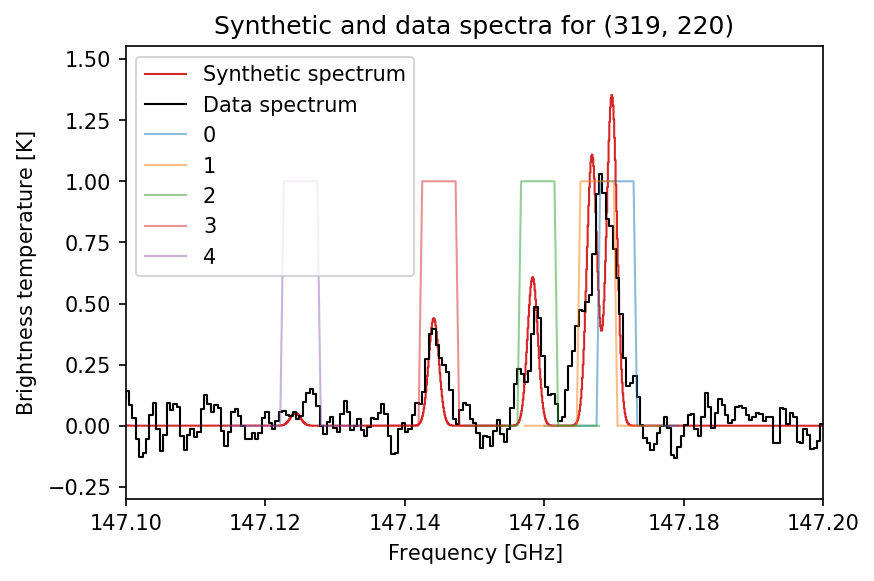

In [104]:
# fig = plt.figure(dpi = display_dpi)
mod_sp.plotter(label = 'Synthetic spectrum', color = 'tab:red', linewidth = 1)
data_sp_K_pyspeckit.plotter(axis=mod_sp.plotter.axis, clear = False, color = 'k', linewidth = 1,
                            xmin = fmin, xmax = fmax, ymin = min(mod) - 0.3, ymax = max(mod) + 0.2, 
                            label = 'Data spectrum', 
                            xlabel = f"Frequency [{mod_sp.xarr.unit.to_string('latex_inline')}]", 
                            ylabel = f"Brightness temperature [{mod_sp.unit.to_string('latex_inline')}]")

for i in range(0, 5):

    # Import masked cube and get channel width
    masked_cube = SpectralCube.read(f'methyl_cyanide/ch3cn_{i}_masked.fits', format='fits')
    plt.plot(masked_cube.with_spectral_unit(u.GHz, rest_value=ch3cn_freqs[7-i]).spectral_axis,
             masked_cube.mask.include()[:,pixel_y,pixel_x], '-', alpha=0.5, linewidth=1,
            label=str(i))

plt.title(f"Synthetic and data spectra for ({pixel_x}, {pixel_y})")
plt.legend() # Is this hacking???
data_sp_K_pyspeckit.plotter.savefig('../figures/ch3cn_spec_datasynth.pdf')